In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import VotingClassifier

In [2]:
def draw_ROC_curve(pred_positive_label, y_data):
  fpr, tpr, thresholds = roc_curve(y_data, pred_positive_label)
  precisions, recalls, thresholds = roc_curve(y_data, pred_positive_label)
  plt.figure(figsize=(15, 5))
  plt.plot([0, 1], [0, 1], label='STR')
  plt.plot(fpr, tpr, label='ROC')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.grid()
  plt.show()
  print('roc_auc_score:', roc_auc_score(y_data, pred_positive_label))

def model_evaluation(y_data, predicted):
  print("MSE:", (mean_squared_error(y_data, predicted)))
  print("r2_score:", r2_score(y_data, predicted))
  print(classification_report(y_data, predicted))

In [3]:
train = pd.read_csv('../randomforest/train_processed.csv')

In [4]:
train

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,1,1,0.671702,-0.913809,-0.642199,-0.448815,-0.199457,0.636434,0.681269,-0.729397,-0.560901,-0.465291,1
1,2,2,1.043116,-1.798289,-1.350846,-1.259418,-0.956001,1.662224,0.847728,-1.032804,-0.685925,0.009629,1
2,3,3,1.856688,-1.232222,-1.504067,-1.496667,-2.109731,-0.902250,-1.593680,1.256536,-0.435876,-0.374349,1
3,4,4,-0.035752,-1.462187,-1.178472,-1.041939,-0.691210,1.662224,1.069675,-1.032804,-0.560901,1.393971,1
4,5,5,1.449902,-0.896120,-1.063556,-1.378043,-2.052990,-3.851394,-1.704654,-0.039837,-0.810950,0.302665,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,3296,2,0.896361,-0.173770,-0.220368,-0.056342,-0.682610,-0.089462,-0.909499,-0.652118,-0.748952,0.660752,0
3296,3297,3,1.614381,-1.623131,-1.710886,-1.807024,-1.973620,-1.094424,-1.688022,1.275851,-1.061000,-0.934382,0
3297,3298,4,-0.910964,0.912511,0.916527,0.891618,0.909954,0.101534,-0.315840,1.454347,0.241032,-0.326925,0
3298,3299,5,-0.952384,0.979646,1.036035,0.931877,0.857713,-0.849226,-1.584084,1.919338,1.586145,-1.007147,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=['day', 'id', 'rainfall']), 
                                                    train['rainfall'], test_size=0.2, random_state=42)

In [6]:
param_grid = {'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.8875


In [7]:
best_model = grid_search.best_estimator_
submission_proba = best_model.predict_proba(X_test)[:, 1]

In [8]:
# choosing different RF models and combine them

results_df = pd.DataFrame(grid_search.cv_results_)
top5 = results_df.sort_values(by='mean_test_score', ascending=False).head(5)
for i, row in top5.iterrows():
    print(f"Rank {i+1}")
    print(f"Mean Accuracy: {row['mean_test_score']:.4f}")
    print(f"Parameters: {row['params']}")
    print('-' * 40)

Rank 38
Mean Accuracy: 0.8875
Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
----------------------------------------
Rank 39
Mean Accuracy: 0.8871
Parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------
Rank 12
Mean Accuracy: 0.8871
Parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------
Rank 21
Mean Accuracy: 0.8867
Parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------
Rank 48
Mean Accuracy: 0.8867
Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
----------------------------------------


In [9]:
rf1 = RandomForestClassifier(criterion='entropy', max_depth=15,
                             min_samples_split=2, n_estimators=100, random_state=42)
rf1.fit(X_train, y_train)

rf2 = RandomForestClassifier(criterion='entropy', max_depth=15,
                             min_samples_split=2, n_estimators=200, random_state=42)
rf2.fit(X_train, y_train)
rf3 = RandomForestClassifier(criterion='gini', max_depth=15,
                             min_samples_split=2, n_estimators=200, random_state=42)
rf3.fit(X_train, y_train)

ensemble_model = VotingClassifier(estimators=[('rf1', rf1), ('rf2', rf2), ('rf3', rf3)],
    voting='soft')
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf1',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=15,
                                                     random_state=42)),
                             ('rf2',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('rf3',
                              RandomForestClassifier(max_depth=15,
                                                     n_estimators=200,
                                                     random_state=42))],
                 voting='soft')

In [10]:
print(rf1.predict(X_test))
print("accuracy:", rf1.score(X_test, y_test))
print("accuracy:", ensemble_model.score(X_test, y_test))

[1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 1
 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1
 1 1 1 1 1 1 0 1 0 1 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1
 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0
 0 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0
 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1
 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1
 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 1 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 0 1 1 

In [11]:
print(rf1.predict_proba(X_test))

[[0.01       0.99      ]
 [0.25111111 0.74888889]
 [0.06299861 0.93700139]
 ...
 [0.97       0.03      ]
 [0.23231565 0.76768435]
 [0.28720793 0.71279207]]


In [12]:
model_evaluation(y_test, rf1.predict(X_test))
model_evaluation(y_test, ensemble_model.predict(X_test))

MSE: 0.09848484848484848
r2_score: 0.6060461357625624
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       328
           1       0.90      0.91      0.90       332

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660

MSE: 0.09696969696969697
r2_score: 0.6121069644431385
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       328
           1       0.90      0.91      0.90       332

    accuracy                           0.90       660
   macro avg       0.90      0.90      0.90       660
weighted avg       0.90      0.90      0.90       660



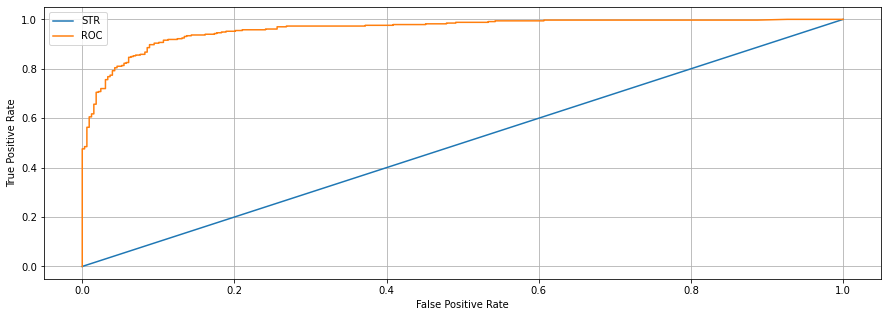

roc_auc_score: 0.9608112327358213


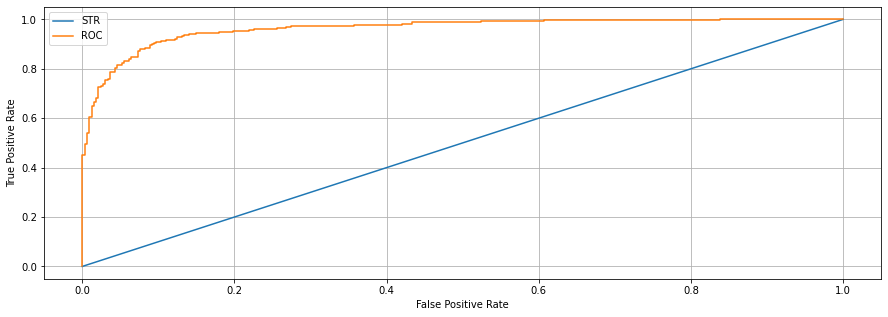

roc_auc_score: 0.9621106376726418


In [13]:
draw_ROC_curve(rf1.predict_proba(X_test)[:, 1], y_test)
draw_ROC_curve(ensemble_model.predict_proba(X_test)[:, 1], y_test)